In [1]:
from __future__ import print_function

import os
import json
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs

from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

%matplotlib inline

In [2]:
MONGO_URL_INPUT = "mongodb://192.168.0.20:27017/yelp.user?ssl=false"
MONGO_URL_OUTPUT = "mongodb://192.168.0.20:27017/yelp.teste"

spark = SparkSession.builder \
    .appName("kmeans-spark") \
    .master("spark://e1dad2a5ae8d:7077") \
    .config("spark.mongodb.input.uri", MONGO_URL_INPUT) \
    .config("spark.mongodb.output.uri", MONGO_URL_OUTPUT) \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.0')\
    .getOrCreate()
sqlContext = SQLContext(spark)

In [3]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
df.head()

Row(_id=Row(oid='60120294d445e70df8e8bd9f'), average_stars=3.57, compliment_cool=22, compliment_cute=0, compliment_funny=22, compliment_hot=3, compliment_list=1, compliment_more=2, compliment_note=11, compliment_photos=0, compliment_plain=15, compliment_profile=1, compliment_writer=10, cool=227, elite='', fans=14, friends='oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg, IkRib6Xs91PPW7pon7VVig, A8Aq8f0-XvLBcyMk2GJdJQ, eEZM1kogR7eL4GOBZyPvBA, e1o1LN7ez5ckCpQeAab4iw, _HrJVzFaRFUhPva8cwBjpQ, pZeGZGzX-ROT_D5lam5uNg, 0S6EI51ej5J7dgYz3-O0lA, woDt8raW-AorxQM_tIE2eA, hWUnSE5gKXNe7bDc8uAG9A, c_3LDSO2RHwZ94_Q6j_O7w, -uv1wDiaplY6eXXS0VwQiA, QFjqxXn3acDC7hckFGUKMg, ErOqapICmHPTN8YobZIcfQ, mJLRvqLOKhqEdkgt9iEaCQ, VKX7jlScJSA-ja5hYRw12Q, ijIC9w5PRcj3dWVlanjZeg, CIZGlEw-Bp0rmkP8M6yQ9Q, OC6fT5WZ8EU7tEVJ3bzPBQ, UZSDGTDpycDzrlfUlyw2dQ, deL6e_z9xqZTIODKqnvRXQ, 5mG2ENw2PylIWElqHSMGqg, Uh5Kug2fvDd51RYmsNZkGg, 4dI4uoShugD9z84fYupelQ, EQpFHqGT9Tk6YSwORTtwpg, o4EGL2-ICGmRJzJ3GxB-vw, s8gK7sdVzJcYKcPv2dkZXw, vOY

### Spark withColumn() is a DataFrame function that is used to add a new column to DataFrame, change the value of an existing column, convert the datatype of a column, derive a new column from an existing column.

In [4]:
FEATURES_COL = ['review_count', 'useful', 'funny', 'cool', 'fans', 'average_stars']
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col, df[col].cast('float'))
    else:
        df = df.drop(col)
df = df.na.drop()
df.columns
df.head()

Row(average_stars=3.569999933242798, cool=227.0, fans=14.0, funny=225.0, review_count=553.0, useful=628.0)

### Spark's implementation of KMeans is a bit different from for example scikit-learn's version. We need to store all features as an array of floats, and store this array as a column called "features". Since we do no longer need the original columns we filter them out with a select statement.

In [5]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df)
df_kmeans.show()

+-------------+------+-----+------+------------+------+--------------------+
|average_stars|  cool| fans| funny|review_count|useful|            features|
+-------------+------+-----+------+------------+------+--------------------+
|         3.57| 227.0| 14.0| 225.0|       553.0| 628.0|[553.0,628.0,225....|
|         3.84| 400.0| 27.0| 316.0|       564.0| 790.0|[564.0,790.0,316....|
|         3.44| 103.0|  5.0| 125.0|        60.0| 151.0|[60.0,151.0,125.0...|
|         3.08|  84.0|  6.0| 160.0|       206.0| 233.0|[206.0,233.0,160....|
|         4.37| 512.0| 78.0| 400.0|       485.0|1265.0|[485.0,1265.0,400...|
|         2.88| 155.0| 15.0| 192.0|       186.0| 642.0|[186.0,642.0,192....|
|         3.63|2878.0|137.0|2446.0|       822.0|4127.0|[822.0,4127.0,244...|
|         3.75|  34.0|  4.0|  21.0|        14.0|  68.0|[14.0,68.0,21.0,3...|
|          4.1| 426.0| 31.0| 372.0|       218.0| 587.0|[218.0,587.0,372....|
|          3.8|   8.0|  5.0|   0.0|         5.0|   6.0|[5.0,6.0,0.0,8.0,...|

In [6]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

In [7]:
transformed = model.transform(df_kmeans)
rows = transformed.collect()
print(rows[:3])

[Row(average_stars=3.569999933242798, cool=227.0, fans=14.0, funny=225.0, review_count=553.0, useful=628.0, features=DenseVector([553.0, 628.0, 225.0, 227.0, 14.0, 3.57]), prediction=9), Row(average_stars=3.8399999141693115, cool=400.0, fans=27.0, funny=316.0, review_count=564.0, useful=790.0, features=DenseVector([564.0, 790.0, 316.0, 400.0, 27.0, 3.84]), prediction=9), Row(average_stars=3.440000057220459, cool=103.0, fans=5.0, funny=125.0, review_count=60.0, useful=151.0, features=DenseVector([60.0, 151.0, 125.0, 103.0, 5.0, 3.44]), prediction=0)]


In [8]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+------------------+------+-----+------+------------+------+--------------------+----------+
|     average_stars|  cool| fans| funny|review_count|useful|            features|prediction|
+------------------+------+-----+------+------------+------+--------------------+----------+
| 3.569999933242798| 227.0| 14.0| 225.0|       553.0| 628.0|[553.0,628.0,225....|         9|
|3.8399999141693115| 400.0| 27.0| 316.0|       564.0| 790.0|[564.0,790.0,316....|         9|
| 3.440000057220459| 103.0|  5.0| 125.0|        60.0| 151.0|[60.0,151.0,125.0...|         0|
|3.0799999237060547|  84.0|  6.0| 160.0|       206.0| 233.0|[206.0,233.0,160....|         0|
| 4.369999885559082| 512.0| 78.0| 400.0|       485.0|1265.0|[485.0,1265.0,400...|         9|
| 2.880000114440918| 155.0| 15.0| 192.0|       186.0| 642.0|[186.0,642.0,192....|         9|
| 3.630000114440918|2878.0|137.0|2446.0|       822.0|4127.0|[822.0,4127.0,244...|         8|
|              3.75|  34.0|  4.0|  21.0|        14.0|  68.0|[14.0,68.0

In [9]:
pddf_pred = df_pred.toPandas()
pddf_pred.head()

,average_stars,cool,fans,funny,review_count,useful,features,prediction
0,3.57,227.0,14.0,225.0,553.0,628.0,"[553.0, 628.0, 225.0, 227.0, 14.0, 3.569999933...",9
1,3.84,400.0,27.0,316.0,564.0,790.0,"[564.0, 790.0, 316.0, 400.0, 27.0, 3.839999914...",9
2,3.44,103.0,5.0,125.0,60.0,151.0,"[60.0, 151.0, 125.0, 103.0, 5.0, 3.44000005722...",0
3,3.08,84.0,6.0,160.0,206.0,233.0,"[206.0, 233.0, 160.0, 84.0, 6.0, 3.07999992370...",0
4,4.37,512.0,78.0,400.0,485.0,1265.0,"[485.0, 1265.0, 400.0, 512.0, 78.0, 4.36999988...",9


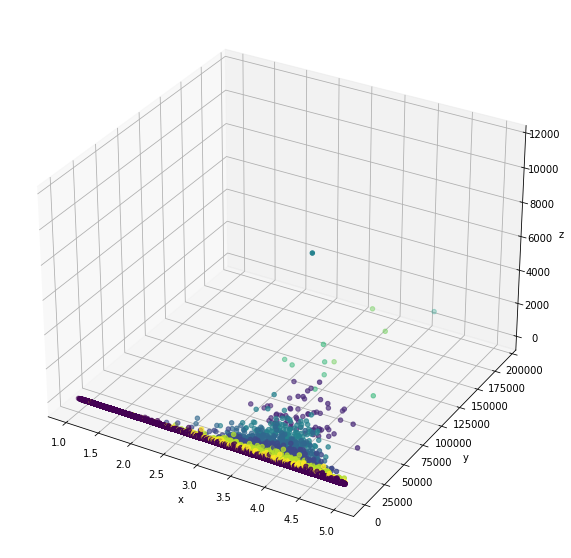

In [10]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.average_stars, pddf_pred.cool, pddf_pred.fans, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()